In [1]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    BatchNormalization,
    LeakyReLU,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    GlobalAveragePooling2D
)
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping, LearningRateScheduler

from keras.applications import ResNet50
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
# from keras.optimizers import Adam
# from keras.callbacks import EarlyStopping, LearningRateSchedule
# from keras.callbacks import EarlyStopping, LearningRateScheduler

from keras.regularizers import l2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

import io
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import numpy as np
import tensorflow as tf

import tensorflow as tf

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt

import os
import shutil
import random

import os
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator



In [2]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Install the Kaggle API
!pip install kaggle

# Create a Kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # Change permissions

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
!kaggle datasets download moltean/fruits -p /content/ --unzip


Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
100% 963M/964M [00:45<00:00, 24.6MB/s]
100% 964M/964M [00:45<00:00, 22.4MB/s]


In [6]:


# Paths to the train and test directories
train_dir = "/content/fruits-360_dataset_100x100/fruits-360/Training/"
test_dir = "/content/fruits-360_dataset_100x100/fruits-360/Test/"

# Output directories for the selected classes
random_train_dir = "random_train_dir"
random_test_dir = "random_test_dir"

# Create output directories if they don't exist
os.makedirs(random_train_dir, exist_ok=True)
os.makedirs(random_test_dir, exist_ok=True)

# List all available classes in the dataset
train_classes = os.listdir(train_dir)
test_classes = os.listdir(test_dir)

# Randomly select 10 classes (ensure classes exist in both train and test)
selected_classes = random.sample(train_classes, 10)
print("Selected Classes:", selected_classes)

def transfer_classes(source_dir, dest_dir, selected_classes):
    for class_name in selected_classes:
        src_class_dir = os.path.join(source_dir, class_name)
        dest_class_dir = os.path.join(dest_dir, class_name)
        if os.path.exists(src_class_dir):
            shutil.copytree(src_class_dir, dest_class_dir, dirs_exist_ok=True)
            print(f"Copied {class_name} from {source_dir} to {dest_dir}")

# Transfer the selected classes
transfer_classes(train_dir, random_train_dir, selected_classes)
transfer_classes(test_dir, random_test_dir, selected_classes)

print("Random selection and transfer completed.")


Selected Classes: ['Corn Husk 1', 'Cantaloupe 2', 'Eggplant long 1', 'Mandarine 1', 'Lemon 1', 'Peach 2', 'Nectarine 1', 'Potato White 1', 'Eggplant 1', 'Apple 6']
Copied Corn Husk 1 from /content/fruits-360_dataset_100x100/fruits-360/Training/ to random_train_dir
Copied Cantaloupe 2 from /content/fruits-360_dataset_100x100/fruits-360/Training/ to random_train_dir
Copied Eggplant long 1 from /content/fruits-360_dataset_100x100/fruits-360/Training/ to random_train_dir
Copied Mandarine 1 from /content/fruits-360_dataset_100x100/fruits-360/Training/ to random_train_dir
Copied Lemon 1 from /content/fruits-360_dataset_100x100/fruits-360/Training/ to random_train_dir
Copied Peach 2 from /content/fruits-360_dataset_100x100/fruits-360/Training/ to random_train_dir
Copied Nectarine 1 from /content/fruits-360_dataset_100x100/fruits-360/Training/ to random_train_dir
Copied Potato White 1 from /content/fruits-360_dataset_100x100/fruits-360/Training/ to random_train_dir
Copied Eggplant 1 from /cont

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths and parameters
image_shape = (100, 100)  # Resize all images to 224x224
batch_size = 32  # Batch size for loading data

# Initialize ImageDataGenerator for training/validation and test
train_valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Random rotation
    width_shift_range=0.2,  # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,  # Random shearing
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flips
    validation_split=0.125  # 10% out of the 80% data for validation (10/80 = 0.125)
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Only rescaling for test data

# Create training data generator (70% of the total dataset)
print("Training Images:")
train_data = train_valid_datagen.flow_from_directory(
    '/content/random_train_dir/',
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Specify training subset (70% of total)
)

# Create validation data generator (10% of the total dataset)
print("Validating Images:")
valid_data = train_valid_datagen.flow_from_directory(
    '//content/random_train_dir',
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset='validation',
    seed = 42# Specify validation subset (10% of total)
)

# Create test data generator (20% of the total dataset)
print("Test Images:")
test_data = test_datagen.flow_from_directory(
    '/content/random_test_dir/',
    target_size=image_shape,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Training Images:
Found 4201 images belonging to 10 classes.
Validating Images:
Found 596 images belonging to 10 classes.
Test Images:
Found 1601 images belonging to 10 classes.


In [8]:
# Extract class names from the datasets using class_indices
train_class_names = list(train_data.class_indices.keys())
valid_class_names = list(valid_data.class_indices.keys())
test_class_names = list(test_data.class_indices.keys())

# Print class names
print("Training Class Names:", train_class_names)
print("Validation Class Names:", valid_class_names)
print("Test Class Names:", test_class_names)

# Print the number of classes
print("Number of Training Classes:", len(train_class_names))
print("Number of Validation Classes:", len(valid_class_names))
print("Number of Test Classes:", len(test_class_names))

class_names = train_class_names
class_names

Training Class Names: ['Apple 6', 'Cantaloupe 2', 'Corn Husk 1', 'Eggplant 1', 'Eggplant long 1', 'Lemon 1', 'Mandarine 1', 'Nectarine 1', 'Peach 2', 'Potato White 1']
Validation Class Names: ['Apple 6', 'Cantaloupe 2', 'Corn Husk 1', 'Eggplant 1', 'Eggplant long 1', 'Lemon 1', 'Mandarine 1', 'Nectarine 1', 'Peach 2', 'Potato White 1']
Test Class Names: ['Apple 6', 'Cantaloupe 2', 'Corn Husk 1', 'Eggplant 1', 'Eggplant long 1', 'Lemon 1', 'Mandarine 1', 'Nectarine 1', 'Peach 2', 'Potato White 1']
Number of Training Classes: 10
Number of Validation Classes: 10
Number of Test Classes: 10


['Apple 6',
 'Cantaloupe 2',
 'Corn Husk 1',
 'Eggplant 1',
 'Eggplant long 1',
 'Lemon 1',
 'Mandarine 1',
 'Nectarine 1',
 'Peach 2',
 'Potato White 1']

In [33]:
resnet = ResNet50(input_shape=(100, 100, 3), weights='imagenet', include_top=False)


In [34]:
resnet

<Functional name=resnet50, built=True>

In [35]:
# Fine-tune the last few layers of ResNet50 (unfreeze last 4 layers for example)
for layer in resnet.layers:
  layer.trainable = False


In [36]:
# Add custom top layers
x = GlobalAveragePooling2D()(resnet.output)  # Global average pooling to reduce spatial dimensions
# x = Dense(128, activation='relu')(x)  # Fully connected layer
# x = BatchNormalization()(x)  # Batch normalization for better convergence
# x = Dropout(0.5)(x)
# x = Dense(256, activation='relu')(x)  # Fully connected layer
# x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(10, activation='softmax')(x)  # Output layer for 10 classes (change as per your dataset)


In [37]:
model = Model(
    inputs = resnet.input,
    outputs = x
)

In [38]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 100, 100, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 106, 106, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 50, 50, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 50, 50, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 50, 50, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 52, 52, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 25, 25, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 25, 25, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 25, 25, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 25, 25, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 25, 25, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 25, 25, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 25, 25, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 25, 25, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 25, 25, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [39]:
# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',  # Correct: pass as a string
    metrics=["accuracy"]
)


In [40]:
# Callbacks for early stopping and learning rate scheduling
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lambda epoch: 1e-3 * 0.9 ** epoch)


In [41]:
# Fit the model
history = model.fit(
    train_data,  # Replace with your training dataset
    validation_data=valid_data,  # Replace with your validation dataset
    epochs=100,
    batch_size=32,
    # steps_per_epoch=len(train_data) // 32,
    # validation_steps=len(valid_data) // 32,
    callbacks=[early_stopping]
)

Epoch 1/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 35s 184ms/step - accuracy: 0.1379 - loss: 2.4979 - val_accuracy: 0.3003 - val_loss: 2.0134
Epoch 2/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 0.2464 - loss: 2.0845 - val_accuracy: 0.2936 - val_loss: 1.9161
Epoch 3/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.3069 - loss: 1.9215 - val_accuracy: 0.4077 - val_loss: 1.7931
Epoch 4/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step - accuracy: 0.3499 - loss: 1.8090 - val_accuracy: 0.4463 - val_loss: 1.7074
Epoch 5/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - accuracy: 0.3680 - loss: 1.7479 - val_accuracy: 0.4513 - val_loss: 1.6550
Epoch 6/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - accuracy: 0.3998 - loss: 1.7044 - val_accuracy: 0.4866 - val_loss: 1.5851
Epoch 7/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step - accuracy: 0.3912 - loss: 1.6557 - val_accuracy: 0.4614 - val_loss: 1.5687
Epoch 8/100
132/132 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.4225 -

In [42]:
model.save("resnet50_model.keras")

# Training and Evaluation


51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step


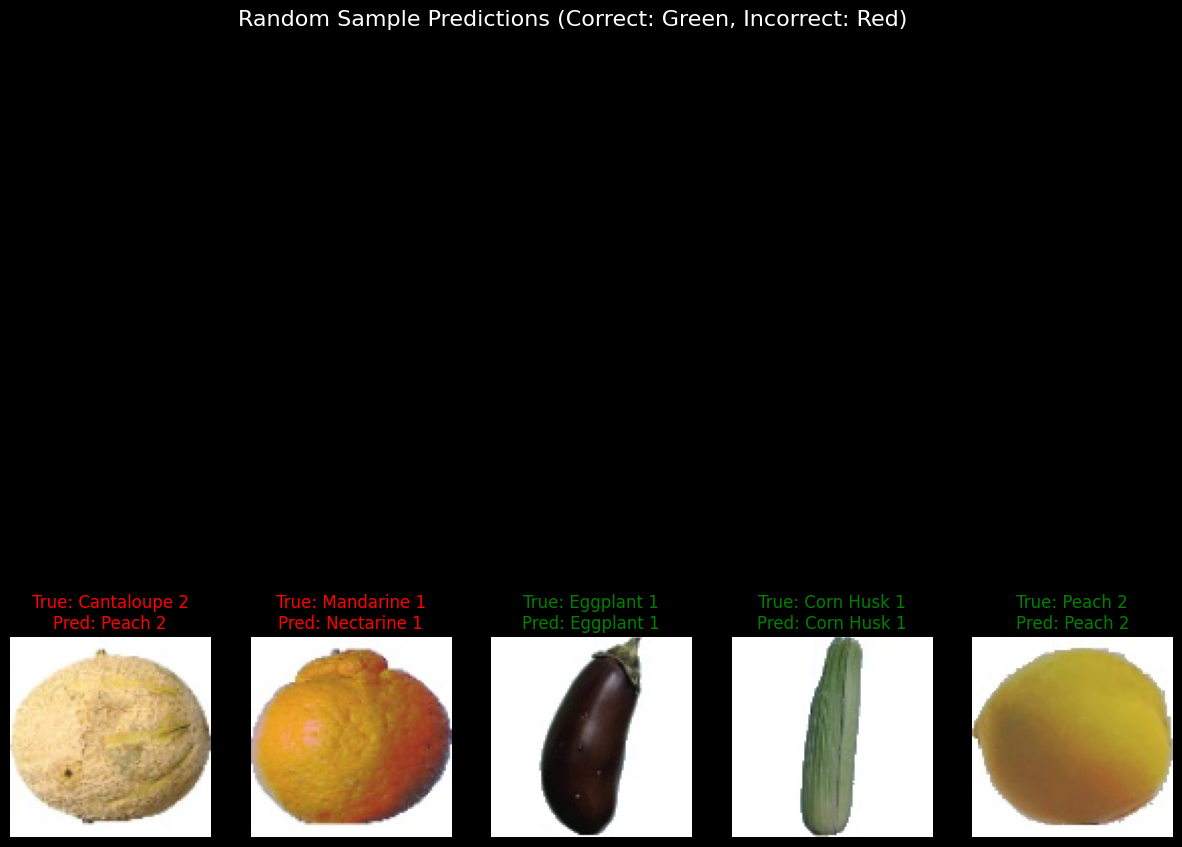

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Collect all images and true labels from the test data generator
X_test_all = []
Y_true_all = []
test_data.reset()  # Reset the generator

for _ in range(len(test_data)):
    X_batch, Y_batch = next(test_data)  # Get a batch of data
    X_test_all.append(X_batch)
    Y_true_all.append(Y_batch)

# Concatenate all batches into single arrays
X_test_all = np.concatenate(X_test_all, axis=0)
Y_true_all = np.concatenate(Y_true_all, axis=0)

# Predict on the entire test dataset
Y_pred = model.predict(X_test_all)  # Predictions for the test set
Y_pred_classes = np.argmax(Y_pred, axis=1)  # Convert predicted probabilities to class indices
Y_true_classes = np.argmax(Y_true_all, axis=1)  # Convert one-hot labels to class indices

# Define class labels (if not already defined)
class_labels = class_names  # Replace with your class names

# Function to randomly sample images and check predictions
def plot_random_samples(X_data, Y_true, Y_pred_classes, class_labels, n=10):
    random_indices = np.random.choice(len(X_data), size=n, replace=False)  # Randomly select `n` indices
    plt.figure(figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, n, i + 1)
        plt.imshow(X_data[idx])  # Assuming images are RGB
        true_label = class_labels[Y_true[idx]]  # Map integer to class name
        pred_label = class_labels[Y_pred_classes[idx]]  # Map integer to class name
        color = "green" if Y_true[idx] == Y_pred_classes[idx] else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.suptitle("Random Sample Predictions (Correct: Green, Incorrect: Red)", fontsize=16)
    plt.show()

# Choose `n` random samples and visualize
n = 5  # Number of random samples to display
plot_random_samples(X_test_all, Y_true_classes, Y_pred_classes, class_labels, n=n)


In [44]:
Y_pred = model.predict(test_data)
score = model.evaluate(test_data)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5828 - loss: 1.3924
Test loss: 1.3054883480072021
Test accuracy: 0.5577763915061951


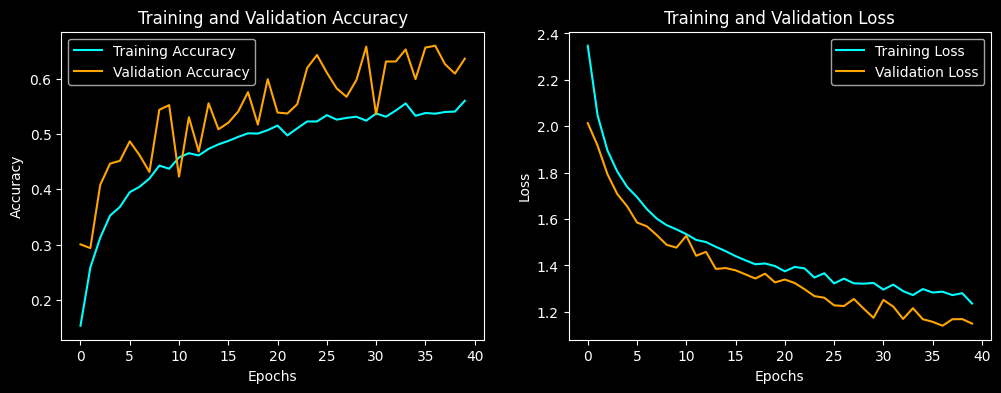

In [45]:

# Define class names (replace these with actual class names if available)
CLASS_NAMES = class_names  # Ensure 'class_names' is defined in your code

# Function to plot accuracy and loss curves
def plot_training_curves(history):
    # Use a dark theme
    plt.style.use('dark_background')
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='cyan')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='cyan')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

# Call the function to plot curves
plot_training_curves(history)


51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Classification Report:
                  precision    recall  f1-score   support

        Apple 6       0.78      0.75      0.77       157
   Cantaloupe 2       1.00      0.35      0.52       164
    Corn Husk 1       1.00      0.56      0.72       154
     Eggplant 1       0.94      0.57      0.71       156
Eggplant long 1       1.00      1.00      1.00        80
        Lemon 1       0.00      0.00      0.00       164
    Mandarine 1       0.02      0.01      0.02       166
    Nectarine 1       0.29      1.00      0.45       164
        Peach 2       0.68      1.00      0.81       246
 Potato White 1       0.61      0.33      0.43       150

       accuracy                           0.56      1601
      macro avg       0.63      0.56      0.54      1601
   weighted avg       0.61      0.56      0.53      1601

Precision: 0.61, Recall: 0.56, F1 Score: 0.53


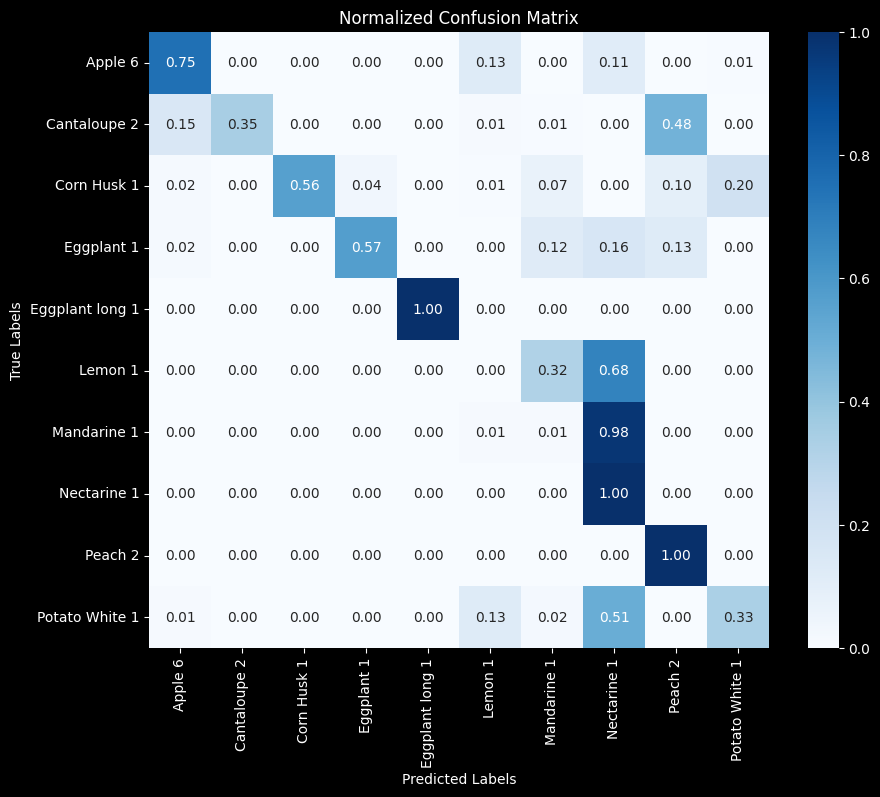

In [46]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Predict on validation data
Y_pred = model.predict(test_data)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = test_data.classes  # Actual class labels from validation data

# Generate a classification report
CLASS_NAMES = list(valid_data.class_indices.keys())  # Extract class names from validation data generator
print("Classification Report:\n", classification_report(Y_true, Y_pred_classes, target_names=class_names))

# Calculate precision, recall, and F1-score
precision = precision_score(Y_true, Y_pred_classes, average='weighted')
recall = recall_score(Y_true, Y_pred_classes, average='weighted')
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f'Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}')

# Calculate normalized confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes, normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names, fmt='.2f')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.show()

# GUI Implementation


In [47]:
import numpy as np
import tensorflow as tf
from PIL import Image
from IPython.display import display, clear_output
import ipywidgets as widgets
import io

# Assuming the following are already defined:
# 1. `model`: Your trained Keras model.
# 2. `test_datagen`: An ImageDataGenerator instance with `rescale=1.0/255.0`.
# 3. `CLASS_NAMES`: A list of class names corresponding to your model's output.

# Define the prediction function
def predict_image(img):
    """
    Preprocess the uploaded image and make a prediction using the trained model.
    """
    # Resize the image
    img_resized = img.resize((100, 100))

    # Convert to numpy array and change dtype to float32
    img_array = np.array(img_resized).astype('float32')

    # Standardize using test_datagen (for normalization)
    img_array = test_datagen.standardize(img_array)

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)
    confidence_scores = predictions[0]
    pred_index = np.argmax(confidence_scores)
    pred_class = CLASS_NAMES[pred_index]
    pred_confidence = confidence_scores[pred_index]

    # Update result label
    result_label.value = f"Prediction: {pred_class}\nConfidence: {pred_confidence:.2f}"

# Define widgets
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
result_label = widgets.Label(value="Upload an image to predict.")

def on_upload_change(change):
    """
    Handle the image upload, display it, and predict the class.
    """
    # Clear previous outputs
    clear_output(wait=True)

    # Display widgets again
    display(widgets.VBox([upload_button, result_label]))

    for name, file_info in upload_button.value.items():
        # Convert uploaded file content to an image
        image_data = io.BytesIO(file_info['content'])
        img = Image.open(image_data)

        # Display the uploaded image
        display(img)

        # Predict and display results
        predict_image(img)

# Attach the handler to the upload button
upload_button.observe(on_upload_change, names='value')

# Display the interface
display(widgets.VBox([upload_button, result_label]))
